## Count telomere-like sequences in a fastq file


In [1]:
import os
import collections
import re
import math
import pathlib
import json
import functools
import operator
import time
from multiprocessing import Process
from io import StringIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import pairwise2  
from Bio.pairwise2 import format_alignment 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
FASTA_PATH='../../fasta/'
CONSENSUS_BLASTED_PATH='../../fasta/asm_out/RaTG13/'
FASTQ_PATH= '../../RaTG13/data/'
FASTQ_FILE= 'Sars_SL3_R1_171127.fastq'

In [4]:
OUT_PATH=CONSENSUS_BLASTED_PATH+'telomere_qc/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [41]:
OUTFILE_BASE=f'{OUT_PATH+FASTQ_FILE.split(".")[0]+"_telomere_two_motif_counts"}'

## fastq reads

In [6]:
readlist=[]
f=FASTQ_PATH+FASTQ_FILE
start_time=time.time()
for record in SeqIO.parse(f, "fastq"):
    readlist.append(record.seq)
end_time=time.time()
print(f'{FASTQ_FILE} read took {end_time-start_time} seconds')

Sars_SL3_R1_171127.fastq read took 238.28608059883118 seconds


In [7]:
len(readlist)

11604666

In [8]:
lengths=[]
for s in readlist:
    lengths.append(len(str(s)))

Min and max read lengths

In [9]:
min(lengths), max(lengths)

(35, 151)

### Telomere like repeats

known telomentic repleat in Homo sapiens

- 'TTAGGG'

4 patterns in DNA:

- TTAGGG #G-quadruplex, direct
- GGGATT #reverse
- AATCCC #complement
- CCCTAA #antisense; reverse complement

In [182]:
TELOMERE_G='TTAGGG' 
TELOMERE_R='GGGATT' #tandem repeat of this sequnce contributes insignificantly for RaTG13 SRA reads
TELOMERE_C='AATCCC' #tandem repeat of this sequnce contributes insignificantly for RaTG13 SRA reads
TELOMERE_RC='CCCTAA' 

TELOMERE_SEQS=[TELOMERE_G, TELOMERE_RC]
TELOMERE_TANDEMS=[x+x for x in TELOMERE_SEQS]

In [183]:
all_motiffs=TELOMERE_TANDEMS
all_motiffs.sort(key=len, reverse=True)

In [184]:
len(all_motiffs)

2

In [44]:
def motiff_subsearch(readseq, motiff_list, lut):
    motiff_list_c=motiff_list.copy()
    seqsplit=[]
    mc=0
    for motiff in motiff_list:
        mc=readseq.count(motiff)
        if motiff in lut:
            lut[motiff]+=mc
        else:
            lut.update({motiff:mc}) 
        if mc>0:
            seqsplit=readseq.split(motiff)
            motiff_list_c.remove(motiff) 
            return mc, seqsplit, motiff_list_c, lut
    return mc, seqsplit, motiff_list_c, lut

In [45]:
def iterloop(readseq, motiff_list, lut):
    mc, seqsplit, motiff_list_c, lut=motiff_subsearch(readseq, motiff_list, lut)
    if mc>0 and len(motiff_list_c)>0:
        for s in seqsplit:
            iterloop(s, motiff_list_c, lut)
    return mc, lut

In [46]:
def write_json(fname, data):
    with open(fname, 'w') as fout:
        json.dump(data, fout)

In [47]:
def motiff_search(reads, motiff_list, outfile):
    lut={}
    start_time=time.time()
    for idx, read in enumerate(reads):
        readseq=str(read)
        mc, lut=iterloop(readseq, motiff_list, lut)
    if outfile:
        write_json(outfile, lut)
    return lut

In [48]:
### Test is working

In [185]:
all_motiffs

['TTAGGGTTAGGG', 'CCCTAACCCTAA']

In [50]:
reads=['AAGTGAGATTAAGGAAGTATTGGGAAGGAGAT']
motiff_list=['GT','AAG','TTA', 'GAGA', 'TTAAGG']
motiff_list.sort(key=len, reverse=True)
lut=motiff_search(reads, motiff_list, outfile=None)
assert lut['TTAAGG'] == 1
assert lut['GAGA'] == 2
assert lut['AAG'] == 3
assert lut['TTA'] == 0
assert lut['GT'] == 0

In [199]:
reads=['TTAGGGTTAGGGTTAGGGTTAGGGATTAGGGTTAGGG']
motiff_list=['TTAGGGTTAGGG','TAGGG']
motiff_list.sort(key=len, reverse=True)
lut=motiff_search(reads, motiff_list, outfile=None)
assert lut['TTAGGGTTAGGG'] == 3
assert lut['TAGGG'] == 0

### get Telomere counts

In [24]:
t_count=0
jobs = []
threads=20

start_time=time.time()
splits = np.array_split(readlist, threads)
print(f'split took {time.time()-start_time} seconds')

split took 1110.454299211502 seconds


In [186]:
t_count=0

In [187]:
print(f'Starting {threads} mutithreading processes')
for nl in splits:
    outfile=OUTFILE_BASE+'_'+str(t_count)+'.json'
    p = Process(target=motiff_search, args=[nl, all_motiffs, outfile])
    jobs.append(p)
    p.start()
    t_count+=1
    print(f'process {t_count} started total: {len(jobs)}', flush=True)

for p in jobs:
    p.join()

Starting 20 mutithreading processes
process 1 started total: 181
process 2 started total: 182
process 3 started total: 183
process 4 started total: 184
process 5 started total: 185
process 6 started total: 186
process 7 started total: 187
process 8 started total: 188
process 9 started total: 189
process 10 started total: 190
process 11 started total: 191
process 12 started total: 192
process 13 started total: 193
process 14 started total: 194
process 15 started total: 195
process 16 started total: 196
process 17 started total: 197
process 18 started total: 198
process 19 started total: 199
process 20 started total: 200


In [188]:
datas=[]
for i in range(threads):
    f = open (f'{OUTFILE_BASE}_{i}.json', "r") 
    data=json.loads(f.read()) 
    datas.append(data)

In [189]:
#or if using single thread
#lut=motiff_search(readlist, all_motiffs)

In [190]:
#stack all the dicts into one
lut = {}
for dictionary in datas:
    for k, v in dictionary.items():
        if k in lut:
            lut[k] = lut[k]+v
        else:
            lut[k] = v

In [191]:
lut.values()

dict_values([14875980, 16461424])

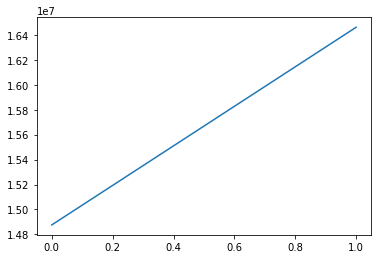

In [192]:
plt.plot(lut.values())

Totals of each motiff

In [193]:
tlut={}
for k,v in lut.items():
    kl=len(k)
    tlut[k]=kl*v

In [194]:
tlut.values()

dict_values([178511760, 197537088])

In [195]:
key_lengths=[]
for k in lut.keys():
    key_lengths.append(len(k))

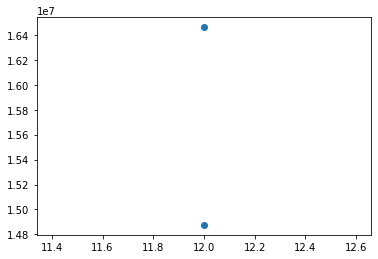

In [196]:
plt.scatter(key_lengths, lut.values())

In [197]:
### Persentage Telomere-like sequences in SRA file

In [198]:
total_chars=sum(tlut.values())
print((total_chars/sum(lengths))*100)

22.814767151627528
